# Tutorial on Feature Visualization

In this notebook we will 
- learn how to visualize concepts using Relevance and Activation Maximization
- compute the receptive field of neurons inside CNN layers
- and use it to crop out the most relevant part of the reference sample
- compute conditional attributions on the reference samples to increase interpretability even further
- customize the FeatureVisualization and ReceptiveField class

In [1]:
%matplotlib inline
#pip install zennit-crp

Let's start again by initializing the VGG16 model and the image of the lizard.

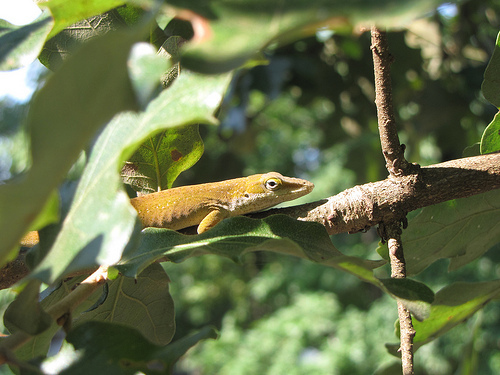

In [3]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

canonizers = [SequentialMergeBatchNorm()]
composite = EpsilonPlusFlat(canonizers)

image = Image.open("VGG16_ImageNet/lizard.JPEG")

image

The _FeatureVisualization_ class contains the functionality to visualize concepts. For this, we must first define what kind of concept is used in which layer of the model by initializing a _layer_map_ dictionary. Moreover, we need a dataset through which we iterate and a _CondAttribution_ object that describes how attributions should be computed on the dataset. It is important not to apply any preprocessing to the images yet. This will be done later in the _FeatureVisualization_ object, so that the built-in plot functions can be used. Otherwise you would have to write your own plot function.

In [ ]:
import torch.nn
import torchvision
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.visualization import FeatureVisualization
from tutorials.VGG16_ImageNet.download_imagenet import download

cc = ChannelConcept()

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}

attribution = CondAttribution(model)

# seperate normalization from resizing for plotting purposes later
transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
preprocessing =  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

path = None #TODO fill or run download below

if path is None:
    path = "ImageNet_data"
    download(path)
    
# apply no normalization here!
imagenet_data = torchvision.datasets.ImageNet(path, transform=transform, split="val")  

Finally, we inherit from the _FeatureVisualization_ class to customize our preprocessing function. It should also be noted that the images are delivered with a bacth dimension of 1, so that they can be fed directly into the model.

In [4]:
fv = FeatureVisualization(attribution, imagenet_data, layer_map, preprocess_fn=preprocessing, path="VGG16_ImageNet")

That's it! Now run the analysis or skip by importing the analysis results for layer features.40 in the example dictionary.

In [5]:
# it will take approximately 25 min on a Titan RXT
#saved_files = fv.run(composite, 0, len(imagenet_data), 32, 100)

In the previous notebook, we discovered the 5 most important concepts in classifying the lizard. Now let's visualize the 8 most presentative input samples for each of these concepts using Relevance Maximization.

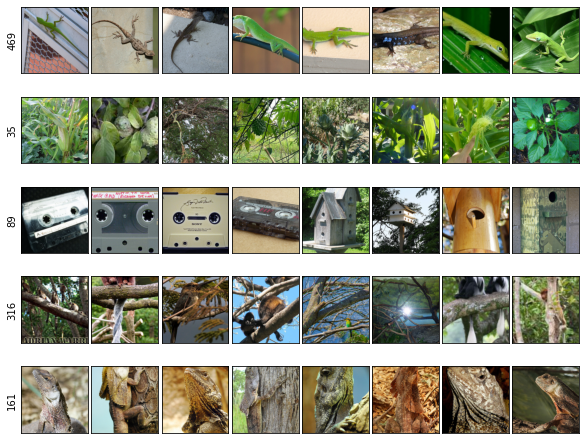

In [6]:
from crp.image import plot_grid

ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8))

plot_grid(ref_c, figsize=(10, 8), padding=False, resize=False)

### Conditonal Heatmaps on Reference Samples

The room for interpretation in the pictures is large. One does not know exactly which part to focus on. Therefore, we can compute conditional heatmaps for the concepts. The intern `attribution` method starts the backward pass directly at the layer of the concept and initializes with the activation of the channel, so that we achieve a localization of the concept in input space.
To achieve this, we set the `heatmap` parameter to True and supply a `composite`.

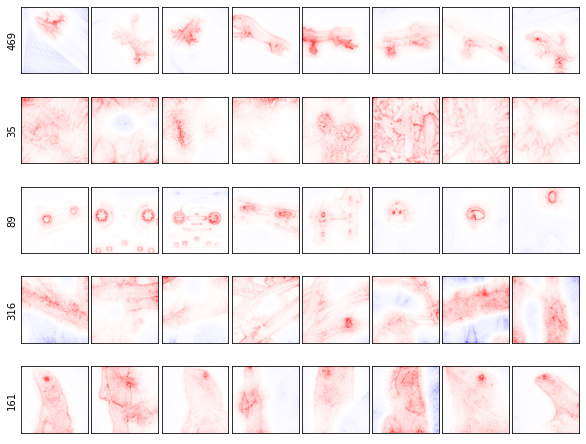

In [7]:
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), heatmap=True, composite=composite)

plot_grid(ref_c, cmap="bwr", symmetric=True, figsize=(10, 8), padding=False, resize=False)

### Add Receptive Field

In addition, we can compute the receptive field of the most relevant neuron to identify how wide a single kernel of a channel can perceive and which part of the input image is most representative.

Now, we compute the receptive field of each concept inside layer 'features.40' and load it into the _FeatureVisualization_ object.

In [8]:
from crp.receptive_field import ReceptiveField

# ReceptiveField needs a dummy input sample
single_sample = fv.get_data_sample(0)[0]
rf = ReceptiveField(attribution, single_sample, path="VGG16_ImageNet")

# TODO: select neuron to crop in rf class

In [9]:
saved_files = rf.run({"features.40": cc}, canonizers)
print(saved_files)

Trace output shapes... finished
Layer features.40:


100%|██████████| 13/13 [00:02<00:00,  5.67it/s]


['VGG16_ImageNet/ReField/features.40.npy']


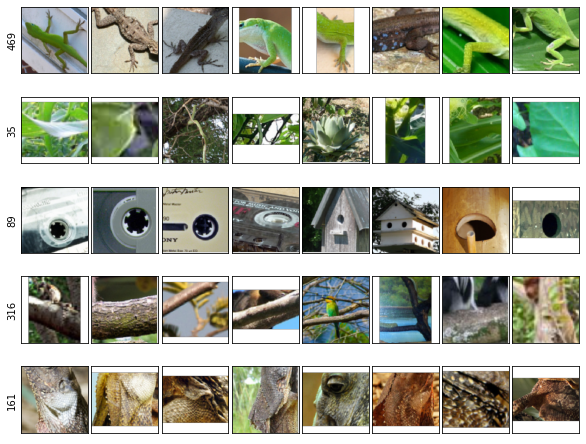

In [10]:
fv.add_receptive_field(rf)

ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), rf=True)

plot_grid(ref_c, figsize=(10, 8), padding=True)

The receptive field can also be applied to the conditional heatmaps.

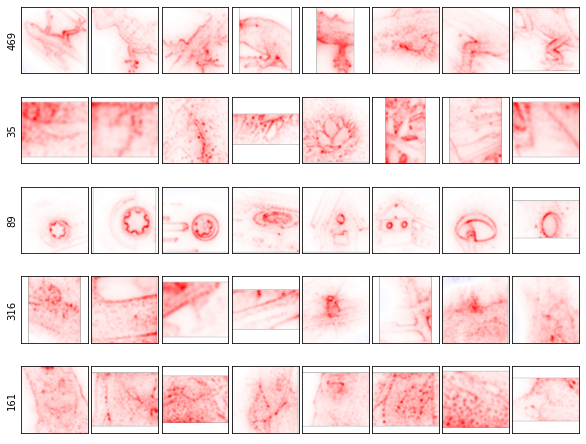

In [11]:
ref_c = fv.get_max_reference([469, 35, 89, 316, 161], "features.40", "relevance", (0, 8), heatmap=True, 
    composite=composite, rf=True)

plot_grid(ref_c, cmap="bwr", symmetric=True, figsize=(10, 8), padding=True)

### Statistics

The library also calculates statistics about the average activation or relevance of a concept. This allows us to determine for which class this concept is most used and which reference images in each class are most representative. This increases the diversity of the reference images, which is beneficial for interpretability.

The method `compute_stats` returns the most representative classes i.e. targets and their mean values. If you set the `norm` parameter, the values are returned w.r.t to the maximal value. Use the `top_N` parameter to return the top-N targets.

If you did not compute the statistics on your own, you can only visualize the example below. Providing files for alle concepts and layer consumes too much disk space.

In [18]:
targets, rel = fv.compute_stats(469, "features.40", "relevance", top_N=5, norm=True)
targets, rel 

(array([46, 41, 40, 44, 39]), tensor([1.0000, 0.9517, 0.9331, 0.8828, 0.8388]))

Similar to `get_max_reference`, the method `get_stats_reference` returns tensors that can be plotted.

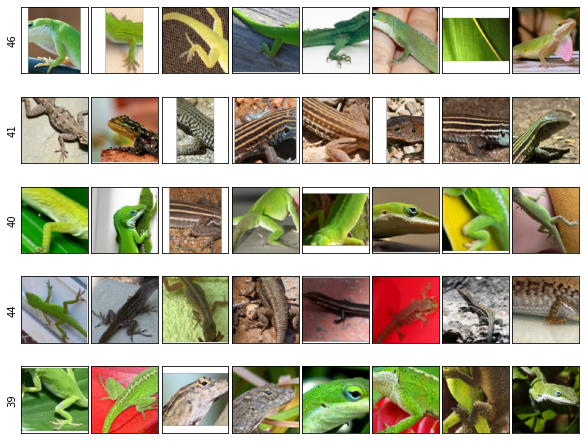

In [20]:
# Images
ref_t = fv.get_stats_reference(469, "features.40", targets, "relevance", (0, 8), rf=True)

plot_grid(ref_t, figsize=(10, 8), padding=True)

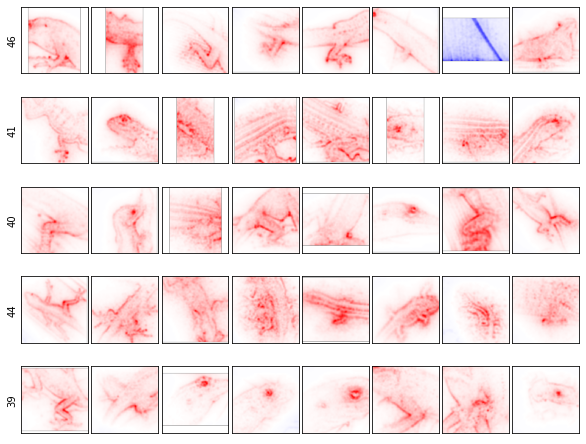

In [21]:
# Heatmaps
ref_t = fv.get_stats_reference(469, "features.40", targets, "relevance", (0, 8), heatmap=True, composite=composite, rf=True)

plot_grid(ref_t, cmap="bwr", symmetric=True, figsize=(10, 8), padding=True)